In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from LB_D2Q9 import pipe_opencl as lb_cl

We now want to visualize the evolution of the flow...let's see how it goes...

In [6]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [7]:
#### Input to the simulation in SI. ######
diameter = 4. # meters
length = 10. # meters

deltaP = -0.005

dr = 0.01
dt = dr**2

viscosity = 10.**-6. # More viscous = easier to simulate!

##### Derived parameters ######
print 'Desired viscosity:' , viscosity
#Re = (input_velocity * diameter)/viscosity
#print 'Desired Re', Re

# Re is set by diameter, input_velocity, and viscosity
# Adjust dr so that mach number doers not explode!
print
print '###### Simulation Parameters #########'
print

# Solve for the desired omega...make sure it's in the correct range.


ly = int(np.ceil(diameter/dr))
lx = int(np.ceil(length/dr))
print 'ly', ly
print 'lx', lx

nx = lx + 1
ny = ly + 1

omega = .5 + (3*dt*viscosity)/(dr**2)

print 'omega:' , omega

assert (omega > 0.5) and (omega < 1)

obstacle_size=.25 # meters

Desired viscosity: 1e-06

###### Simulation Parameters #########

ly 400
lx 1000
omega: 0.500003


In [8]:
import skimage as ski
import skimage.draw

In [9]:
circle_center = np.array([2., 2.])
radius = .3

nondim_center = (circle_center/dr).astype(np.int)
nondim_radius = radius/dr

circle = ski.draw.circle(nondim_center[0], nondim_center[1], nondim_radius)

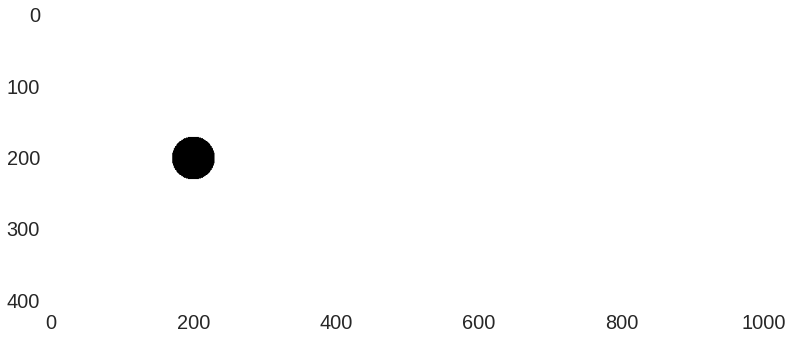

In [10]:
# Create the obstacle

obstacles = np.zeros((nx, ny), dtype=np.int32)
obstacles = np.asfortranarray(obstacles)
obstacles[circle[0], circle[1]] = 1
plt.imshow(obstacles.T)
plt.grid(False)

In [11]:
sim = lb_cl.Pipe_Flow_Obstacles(lx=lx, ly=ly, dr=dr, dt=dt, omega=omega,
                  deltaP = deltaP, obstacle_mask = obstacles)

# U should be on the order of 0.1, 0.2 in the simulation!
#print 'u_max in simulation:' , np.max(sim.u)

The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices
2d global: (1024, 416)
2d local: (32, 32)
3d global: (1024, 416, 9)
3d local: (32, 32, 1)


In [12]:
%%prun

sim.run(1000)

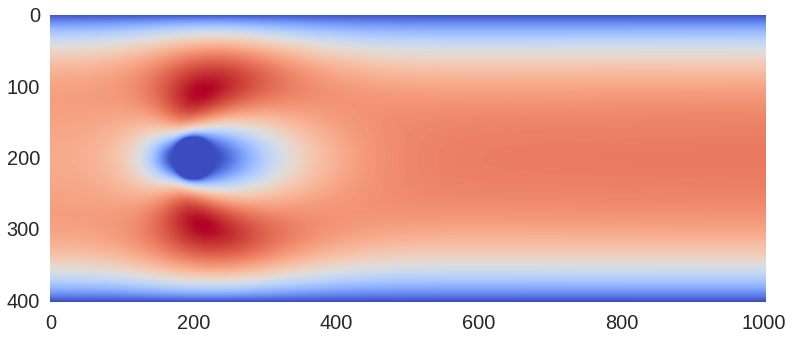

In [14]:
total_num_steps = 5000
steps_per_image= 1000

num_to_record = int(np.ceil(float(total_num_steps)/steps_per_image))

Re_list = []
Ma_list = []

plt.figure()
for i in range(num_to_record):
    fields = sim.get_fields_on_cpu()
    u = fields['u']
    plt.imshow(u.T, cmap = cm.coolwarm)
    plt.grid(False)
    #plt.clim(vmin=0, vmax=1.)
    #if i == 0:
    #    plt.colorbar()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    sim.run(steps_per_image)
plt.clf() # This way a second figure does not appear at the end...

IDK how to convert...but let's just fit.

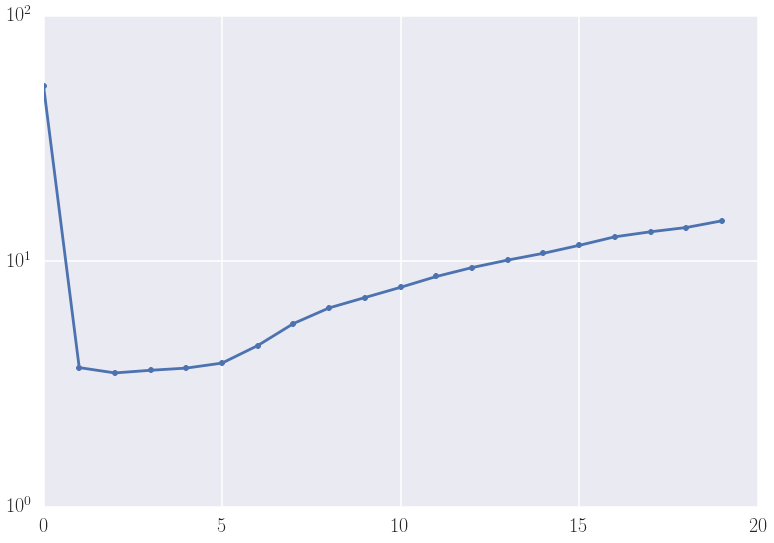

In [47]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

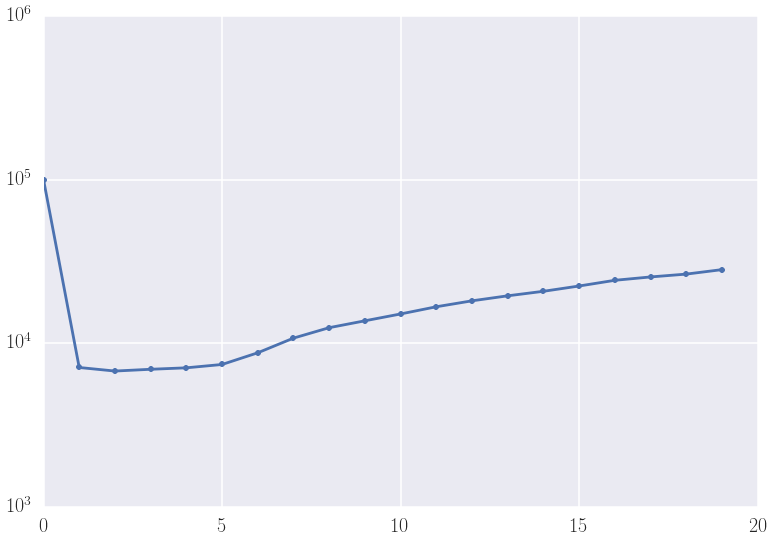

In [48]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!